### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# MiDaS

*Author: Intel ISL*

**MiDaS models for computing relative depth from a single image.**

<img src="https://pytorch.org/assets/images/midas_samples.png" alt="alt" width="50%"/>


### Model Description

[MiDaS](https://arxiv.org/abs/1907.01341) computes relative inverse depth from a single image. The repository provides multiple models that cover different use cases ranging from a small, high-speed model to a very large model that provide the highest accuracy. The models have been trained on 10 distinct datasets using
multi-objective optimization to ensure high quality on a wide range of inputs.

### Dependencies

MiDaS depends on [timm](https://github.com/rwightman/pytorch-image-models). Install with

In [1]:
pip install timm

     |████████████████████████████████| 376 kB 5.2 MB/s 


### Example Usage

Download an image from the PyTorch homepage

In [2]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

In [8]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
import os


Mounted at /content/gdrive/


Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [3]:
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip


Loading weights:  None


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/intel-isl/MiDaS/releases/download/v2_1/model-small-70d6b9c8.pt" to /root/.cache/torch/hub/checkpoints/model-small-70d6b9c8.pt


  0%|          | 0.00/81.8M [00:00<?, ?B/s]

Move model to GPU if available

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

Load transforms to resize and normalize the image for large or small model

In [5]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")


transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

In [9]:
import pickle
train_dir = "gdrive/MyDrive/ECE5554_Fall2021/Project/FastDepth_files/KITTI_Train/"
pkl_file_name = train_dir+"kitty_dataset_val_orig0.pkl"
with open(pkl_file_name, 'rb') as pickle_file:
    dataset = pickle.load(pickle_file)

In [10]:
pkl_file_name = train_dir+"kitty_dataset_val_orig1.pkl"
with open(pkl_file_name, 'rb') as pickle_file:
    dataset1 = pickle.load(pickle_file)
dataset = dataset + dataset1

In [11]:
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

In [12]:
def compute_scale_and_shift(prediction, target, mask):
        # system matrix: A = [[a_00, a_01], [a_10, a_11]]
        a_00 = torch.sum(mask * prediction * prediction, (1, 2))
        a_01 = torch.sum(mask * prediction, (1, 2))
        a_11 = torch.sum(mask, (1, 2))

        # right hand side: b = [b_0, b_1]
        b_0 = torch.sum(mask * prediction * target, (1, 2))
        b_1 = torch.sum(mask * target, (1, 2))

        # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
        x_0 = torch.zeros_like(b_0)
        x_1 = torch.zeros_like(b_1)

        det = a_00 * a_11 - a_01 * a_01
        # A needs to be a positive definite matrix.
        valid = det > 0

        x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
        x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

        return x_0, x_1

In [13]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data

In [14]:
import math
import time
def test_solver(model, test_loader):
  count = 0
  accuracy = []
  avg_time = []
  for x, y in test_loader:
    shape = [y.shape[1],y.shape[2]]
    input_batch = (x).to(device)
    with torch.no_grad():
      t1 = time.time()
      prediction = model(input_batch)
      t2 = time.time()
      prediction = torch.nn.functional.interpolate(
          prediction.unsqueeze(1),
          size=shape,
          mode="bicubic",
          align_corners=False,
      ).squeeze(1)
    mask = y > 0
    target_disparity = torch.zeros_like(y)
    target_disparity[mask == 1] = 1.0 / y[mask == 1]
    scale,shift = compute_scale_and_shift(prediction,target_disparity,mask)
    prediction_aligned = scale.view(-1, 1, 1) * prediction + shift.view(-1, 1, 1)

    disparity_cap = 1.0 / 80
    prediction_aligned[prediction_aligned < disparity_cap] = disparity_cap

    prediciton_depth = 1.0 / prediction_aligned
    prediciton_plot = torch.reshape(prediciton_depth,(prediciton_depth.shape[1],prediciton_depth.shape[2]))
       
    abs_diff = (y - prediciton_depth).abs()
    percent_diff = (abs_diff/y)*100
    total_pixel = percent_diff.shape[1] * percent_diff.shape[2]
    test = percent_diff[percent_diff < 25.0]
    accuracy.append(test.shape[0]/total_pixel)
    avg_time.append(t2-t1)
    count += 1
  print(sum(accuracy)/len(accuracy))
  print(sum(avg_time)/len(avg_time))
  return avg_time

In [15]:
avg_time = test_solver(midas,test_loader)

0.21843068473676042
0.1612932759677708


In [16]:
for i in range(1,11,1):
  url = "https://github.com/burhanb7/FastDepth_model/raw/main/test"+str(i)+".png"
  filename= "test"+str(i)+".png"
  urllib.request.urlretrieve(url, filename)

0.07682681083679199


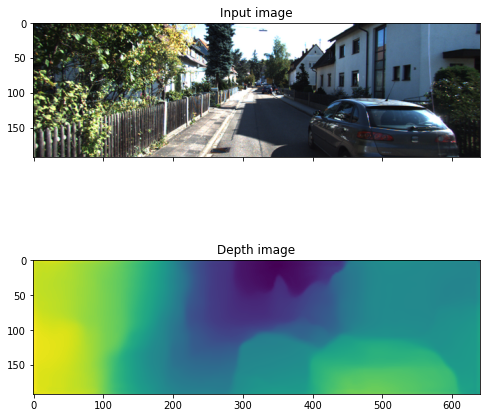

In [17]:
midas.eval()
import time
file = "test3.png"
img = cv2.imread(file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_batch = transform(img).to(device)
with torch.no_grad():
  t1 = time.time()
  prediction = midas(input_batch)
  t2 = time.time()
  prediction = torch.nn.functional.interpolate(
      prediction.unsqueeze(1),
      size=img.shape[:2],
      mode="bicubic",
      align_corners=False,
  ).squeeze()
output = prediction.cpu()
print(t2-t1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
axs[0].set_title('Input image')
axs[0].imshow(img, origin='upper')

axs[1].set_title('Depth image')
axs[1].imshow(output, origin='upper')
plt.show()

In [18]:
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc 
!pip install --quiet pypandoc
!jupyter nbconvert --to PDF "gdrive/MyDrive/ECE5554_Fall2021/Project/midas_v2_test.ipynb"

Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package fonts-droid-fallback.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../00-fonts-droid-fallback_1%3a6.0.1r16-1.1_all.deb ...
Unpacking fonts-droid-fallback (1:6.0.1r16-1.1) ...
Selecting previously unselected package fonts-lato.
Preparing to unpack .../01-fonts-lato_2.0-2_all.deb ...
Unpacking fonts-lato (2.0-2) ...
Selecting previously unselected package poppler-data.
Preparing to unpack .../02-poppler-data_0.4.8-2_all.deb ...
Unpacking poppler-data (0.4.8-2) ...
Selecting previously unselected package tex-common.
Preparing to unpack .../03-tex-common_6.09_all.deb ...
Unpacking tex-common (6.09) ...
Selecting previously unselected package fonts-lmodern.
Preparing to unpack .../04-fonts-lmodern_2.004.5-3_all.deb ...
Unpacking fonts-lmodern (2.004.5-3) ...
Selecting previously unselected package fonts-noto-mono.
Preparing to unpack .

Show result

### References
[Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer](https://arxiv.org/abs/1907.01341)

[Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413)

Please cite our papers if you use our models:

In [ ]:
@article{Ranftl2020,
	author    = {Ren\'{e} Ranftl and Katrin Lasinger and David Hafner and Konrad Schindler and Vladlen Koltun},
	title     = {Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer},
	journal   = {IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)},
	year      = {2020},
}

SyntaxError: ignored

In [ ]:
@article{Ranftl2021,
	author    = {Ren\'{e} Ranftl and Alexey Bochkovskiy and Vladlen Koltun},
	title     = {Vision Transformers for Dense Prediction},
	journal   = {ArXiv preprint},
	year      = {2021},
}